In [501]:
import datetime
import importlib
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

import utils
from utils.download import get_data

In [502]:
_ = importlib.reload(utils.download)

In [503]:
data, params = get_data()

[*********************100%%**********************]  1 of 1 completed


In [504]:
data['returns'] = data.interpolate(type='linear').pct_change()

In [505]:
train, test = data.loc[:params['test']-datetime.timedelta(days=1), ], data.loc[params['test']:, ]

# Metoda historyczna

In [506]:
alpha = .95

In [507]:
def calculate_var(df, method, name):
    df[f'var95_{name}'] = df.returns.rolling(window=125).agg(method)
    df[f'VaR95_{name}'] = df[f'var95_{name}'] * df.Close.shift(-1) + df.Close.shift(-1)
    return df

def exceeds_vector(df, name):
    df[f'exceeds_{name}'] = np.where(df[f'returns'] > data[f'var95_{name}'], 1, 0)
    df.loc[df[f'var95_{name}'].isna(), f'exceeds_{name}'] = np.nan
    df[f'procent_przekroczeń_{name}'] = df[f'exceeds_{name}'].rolling(window=50).sum()/50
    I = df.dropna()[f'exceeds_{name}'] # wektor przekroczeń
    return df, I

In [508]:
data = calculate_var(data, lambda x: np.quantile(x, alpha), 'hist')

Wykres zwrotów i VaR95 dla zwrotów.

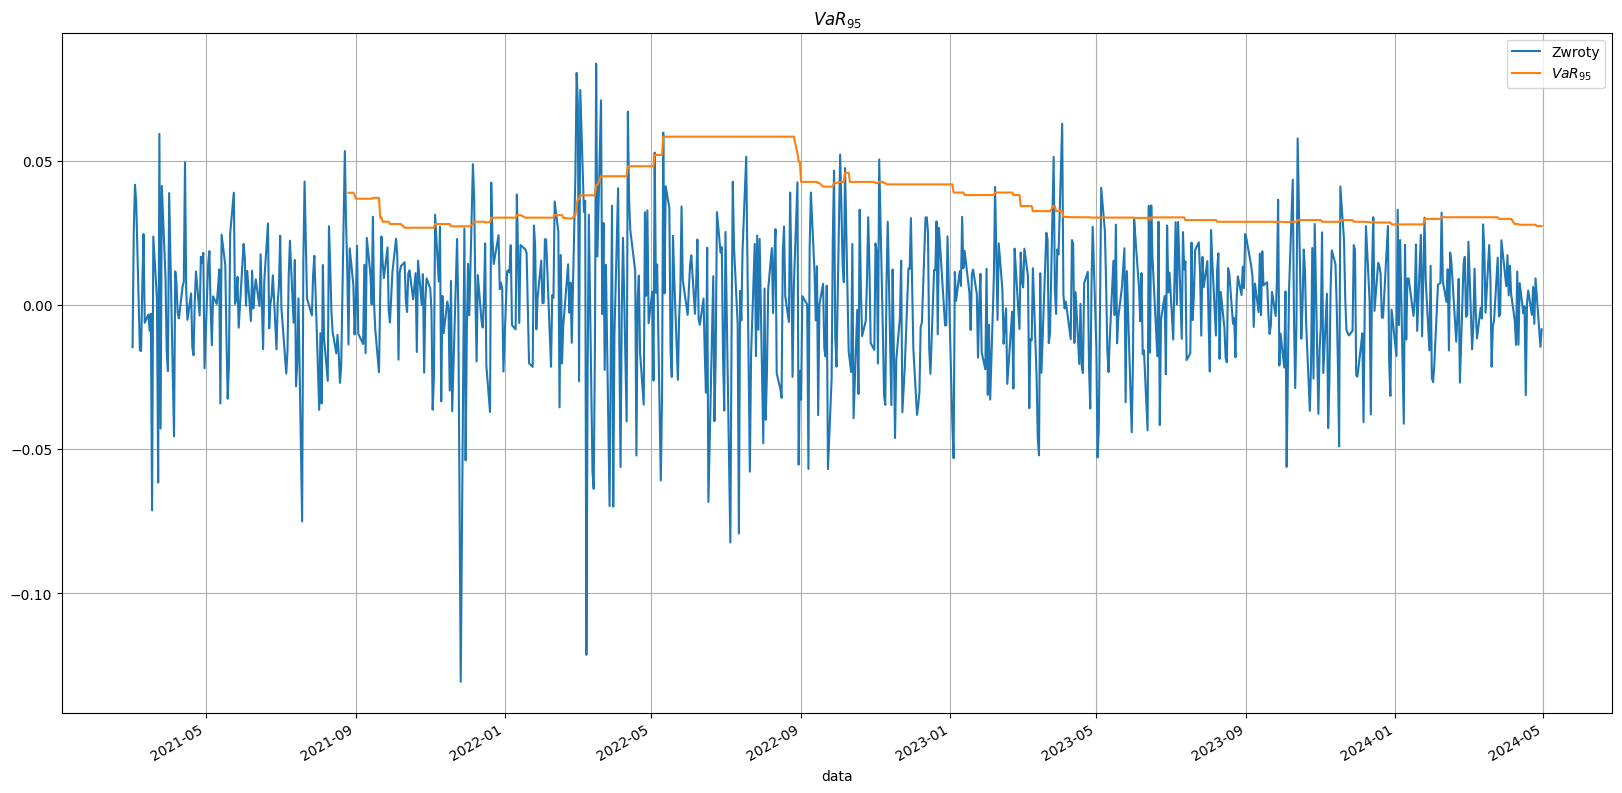

In [509]:
fig, ax = plt.subplots(figsize=(20,10))
_ = data[['returns', 'var95_hist']].\
    plot(ax=ax,
         grid=True,
         xlabel='data',
         title='$VaR_{95}$')
plt.legend(['Zwroty', '$VaR_{95}$'])
plt.savefig(f"pics\\{params['name']}\\var95.png")

Wykres cen i VaR95 dla cen.

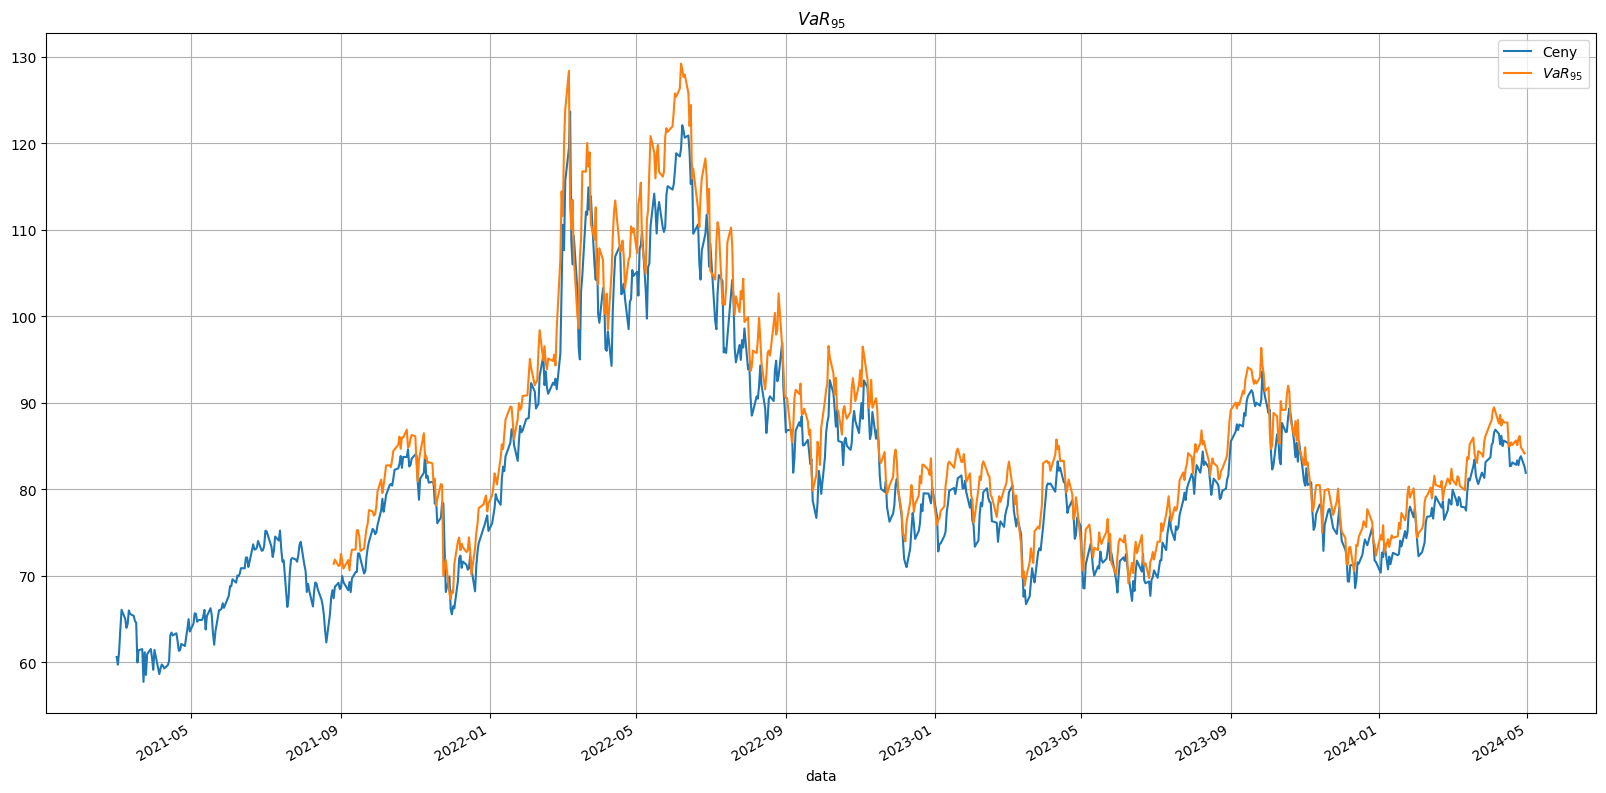

In [510]:
_, ax = plt.subplots(figsize=(20,10))
_ = data[['Close', 'VaR95_hist']].\
    plot(ax=ax,
         grid=True,
         xlabel='data',
         title='$VaR_{95}$')
plt.legend(['Ceny', '$VaR_{95}$'])
plt.savefig(f"pics\\{params['name']}\\var95_ceny.png")

In [511]:
data, I = exceeds_vector(data, 'hist')

In [512]:
# data['exceeds'] = np.where(data['returns'] > data['var95'], 1, 0)
# data.loc[data['var95'].isna(), 'exceeds'] = np.nan
# data['procent przekroczeń'] = data.exceeds.rolling(window=50).sum()/50

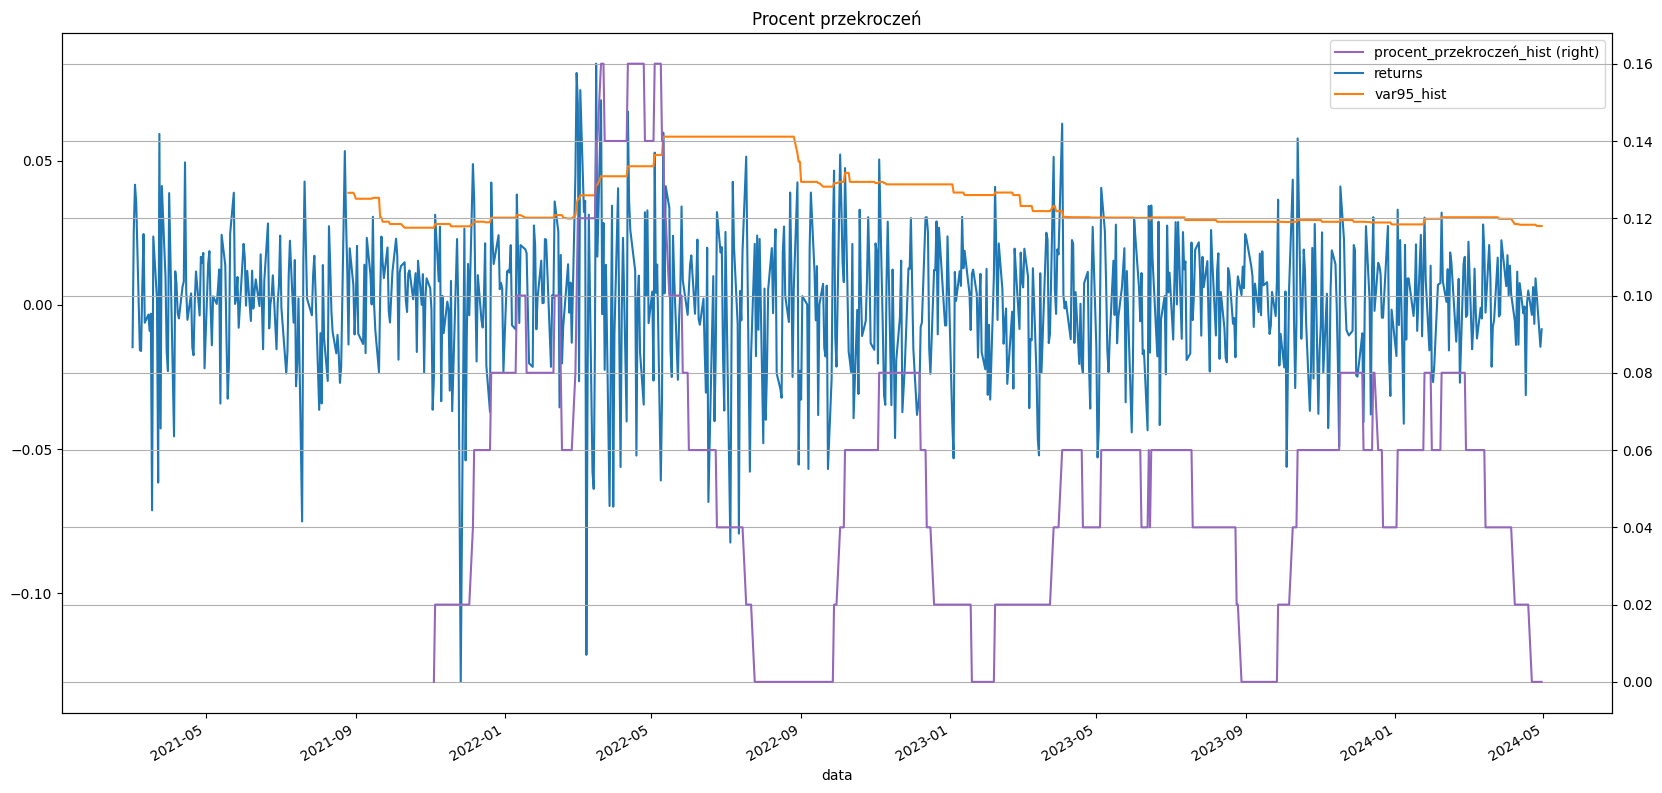

In [513]:
_, ax = plt.subplots(figsize=(20,10))
line1 = data[['procent_przekroczeń_hist']].plot(secondary_y=True,
                                            ax=ax,
                                            color='C4',
                                            legend=True)

_ = data[['returns', 'var95_hist']].plot(ax=ax,
                                         grid=True,
                                         style=['-', '-'],
                                         color=['C0', 'C1'],
                                         xlabel='data',
                                         title='Procent przekroczeń', legend=True)
plt.savefig(f"pics\\{params['name']}\\procent-var95.png")

## Testowanie wsteczne

### Rozkład dwumianowy

In [514]:
print('Średnia z przekroczeń = {}, 1 - {} = {}.\nWariancja z przekroczeń = {}, {}(1 - {}) = {}.'.\
    format(*map(lambda x: np.round(x, 3),
                [I.mean(), alpha, 1- alpha,
                 I.var(), alpha, alpha, alpha * (1 - alpha)])))

Średnia z przekroczeń = 0.053, 1 - 0.95 = 0.05.
Wariancja z przekroczeń = 0.05, 0.95(1 - 0.95) = 0.048.


In [515]:
stats.binomtest(int(I.sum()), n=I.size, p=1-alpha)

BinomTestResult(k=33, n=624, alternative='two-sided', statistic=0.052884615384615384, pvalue=0.713077314362375)

# Metoda ważonej symulacji historycznej

In [516]:
lam = params['lambda']
alpha = 0.95

In [517]:
def weighted_var(losses):
    w1 = 1 / np.sum(lam ** np.arange(len(losses)))
    weights = w1 * lam ** np.arange(len(losses))
    df = pd.DataFrame({'losses': losses, 'weights': weights}).reset_index(drop=True)
    df = df.sort_values(by='losses', ascending=True, ignore_index=True)
    df.weights = df.weights.cumsum()
    return df.loc[df.weights.searchsorted(alpha)-1, 'losses']

In [522]:
data = calculate_var(data, weighted_var, 'ważona')

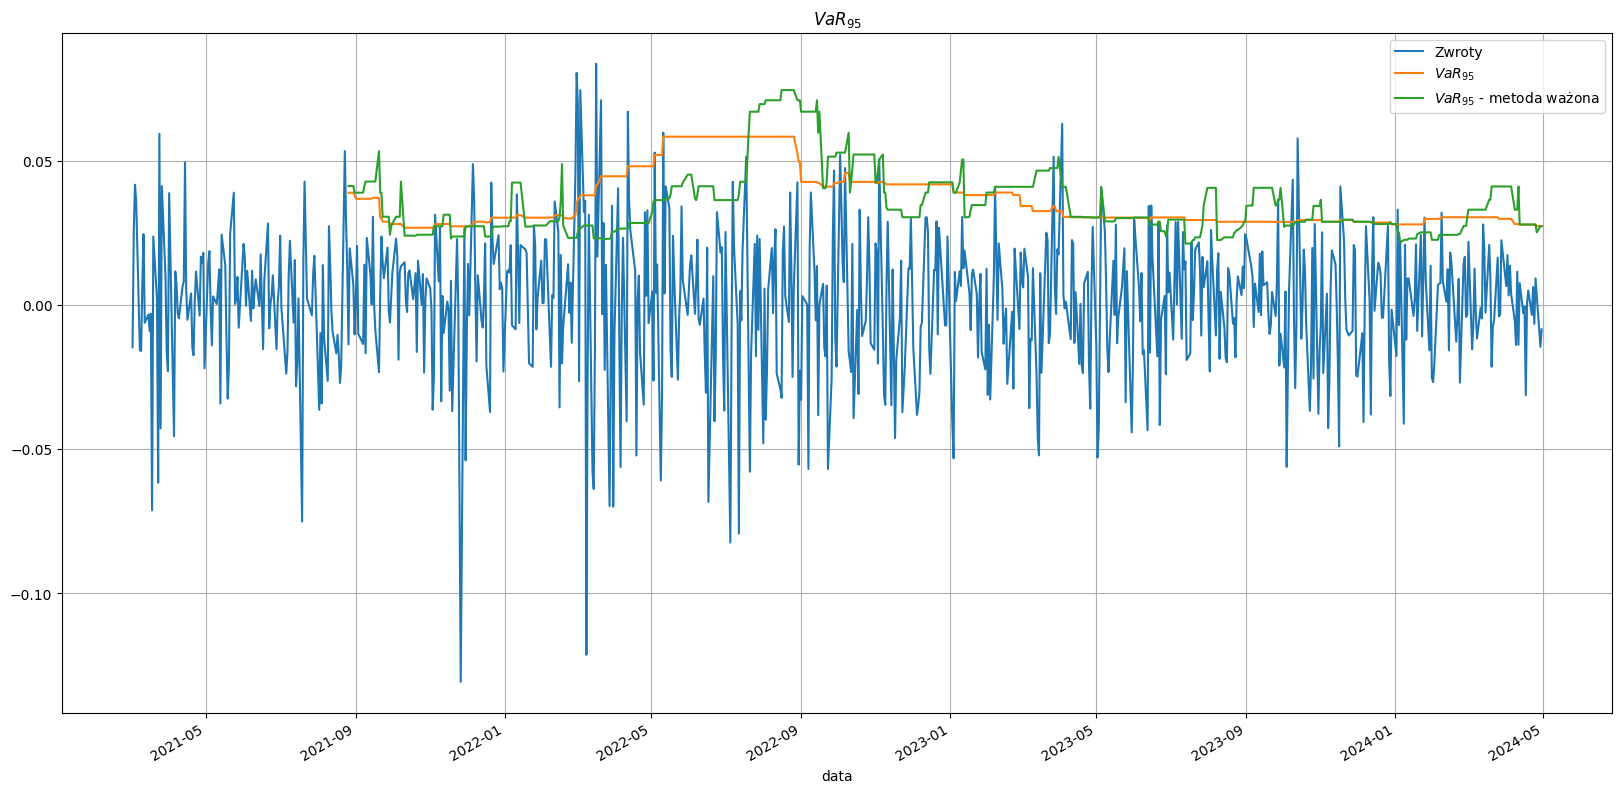

In [525]:
_, ax = plt.subplots(figsize=(20,10))
_ = data[['returns', 'var95_hist','var95_ważona']].\
    plot(ax=ax,
         grid=True,
         xlabel='data',
         title='$VaR_{95}$')
plt.legend(['Zwroty', '$VaR_{95}$', '$VaR_{95}$ - metoda ważona'])
plt.savefig(f'pics\\{params["name"]}\\var95_wazony.png')

In [526]:
data, I_weighted = exceeds_vector(data, 'ważona')

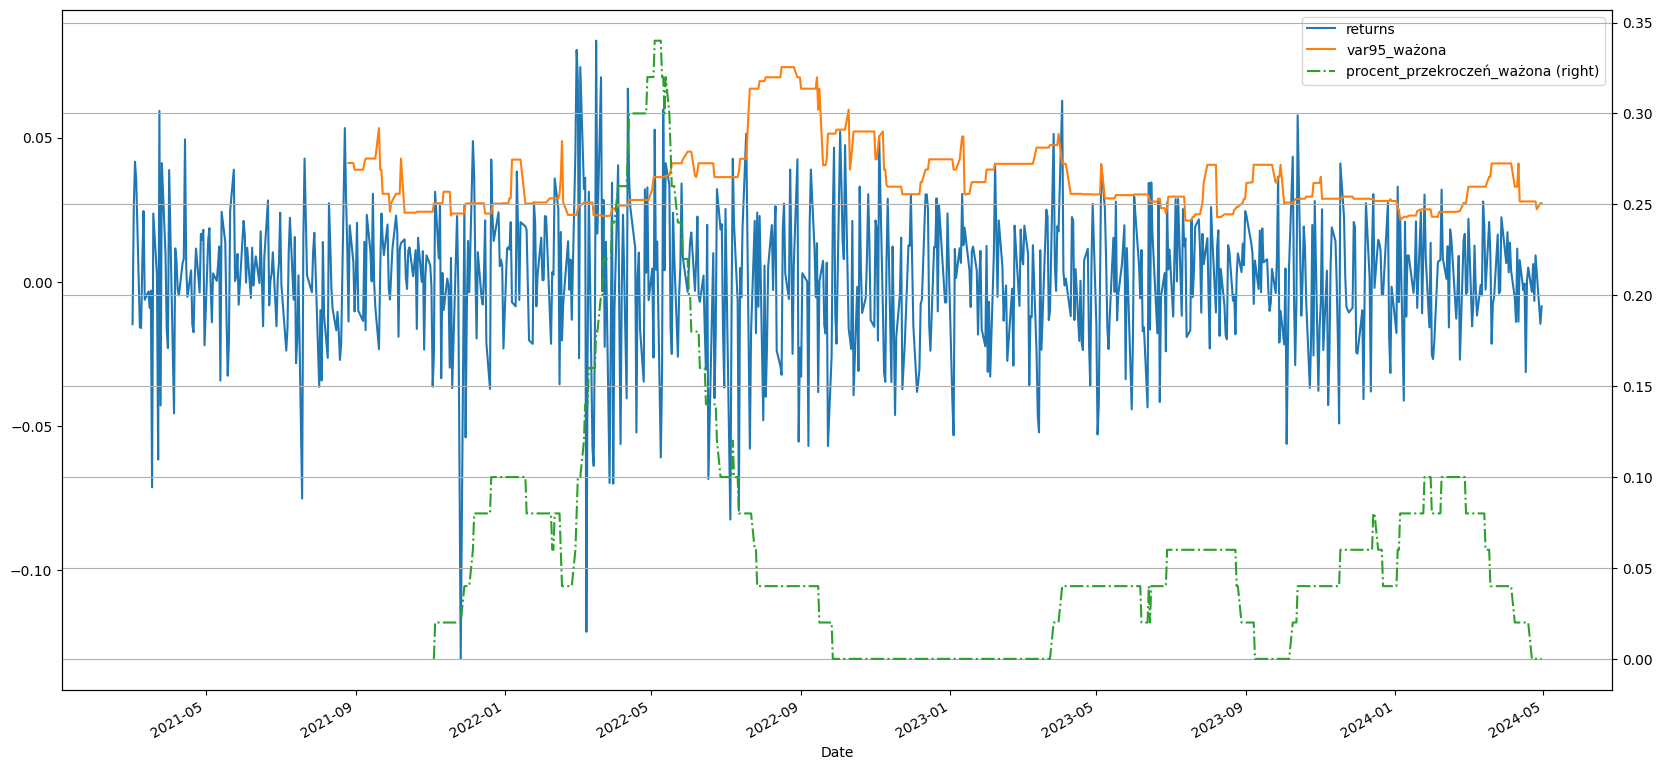

In [527]:
_, ax = plt.subplots(figsize=(20,10))
_ = data[['returns', 'var95_ważona', 'procent_przekroczeń_ważona']].plot(ax=ax,
                                                                         secondary_y=['procent_przekroczeń_ważona'],
                                                                         grid=True,
                                                                         style=['-', '-', '-.'])

## Testowanie wsteczne

### Rozkład dwumianowy

In [528]:
print('Średnia z przekroczeń = {}, 1 - {} = {}.\nWariancja z przekroczeń = {}, {}(1 - {}) = {}.'. \
      format(*map(lambda x: np.round(x, 3),
                  [I_weighted.mean(), alpha, 1 - alpha,
                   I_weighted.var(), alpha, alpha, alpha * (1 - alpha)])))

Średnia z przekroczeń = 0.064, 1 - 0.95 = 0.05.
Wariancja z przekroczeń = 0.06, 0.95(1 - 0.95) = 0.048.


In [529]:
stats.binomtest(int(I_weighted.sum()), n=I_weighted.size, p=1-alpha)

BinomTestResult(k=40, n=624, alternative='two-sided', statistic=0.0641025641025641, pvalue=0.1172789788139323)

# Metoda filtrowanej symulacji historycznej

In [ ]:
from arch import arch_model

In [ ]:
def garch_var(losses):
    losses = losses.dropna() * 100
    model =  arch_model(losses, vol ="GARCH", p=1, q=1, dist="t", mean='constant')
    res = model.fit()
    forecasts = res.forecast(horizon=1)
    variance = forecasts.variance.values[0, 0]
    mean = forecasts.mean.values[0, 0]
    residuals = (res.resid - mean) / res.conditional_volatility
    q = residuals.quantile(alpha)
    return (mean + np.sqrt(variance) * q) / 100

In [ ]:
%%capture
data = calculate_var(data, garch_var, 'garch')

In [ ]:
data, I_garch = exceeds_vector(data, 'garch')

In [ ]:
_, ax = plt.subplots(figsize=(20, 10))
_ = data[['returns', 'var95', 'var95_ważona', 'var95_garch']].plot(grid=True, ax=ax)

In [ ]:
_, ax = plt.subplots(figsize=(20, 10))
_ = data[['returns', 'var95_garch', 'procent_przekroczeń_garch']]. \
    plot(ax=ax, secondary_y=['procent_przekroczeń_garch'], grid=True,
         style=['-', '-', '-.'])

## Testowanie wsteczne

### Rozkład dwumianowy

In [ ]:
print('Średnia z przekroczeń = {}, 1 - {} = {}.\nWariancja z przekroczeń = {}, {}(1 - {}) = {}.'. \
      format(*map(lambda x: np.round(x, 3),
                  [I_garch.mean(), alpha, 1 - alpha,
                   I_garch.var(), alpha, alpha, alpha * (1 - alpha)])))

In [ ]:
stats.binomtest(int(I_garch.sum()), n=I_garch.size, p=1-alpha)